In [2]:
# All Imports
from collections import Counter
from operator import itemgetter
import ConfigParser
import matplotlib.pyplot as plt
import networkx as nx
import sys
import time
import io
import re
import nltk
#nltk.download()
from tabulate import tabulate
from nltk.corpus import sentiwordnet
from nltk.corpus import SentiWordNetCorpusReader, SentiSynset
import pylab as plt

%matplotlib inline
swn_root = './'
swn_filename = 'SentiWordNet_3.0.0_20130122.txt'
swn = SentiWordNetCorpusReader(swn_root,swn_filename,encoding='utf-8')

In [3]:
# Converts a file to list of strings where each item is one line of the file.
def file2string(filename):
    result = []
    result = io.open(filename, encoding='utf8').readlines()
    for val in range(0,len(result)):
        result[val]=re.sub("\n","",result[val])        
    return result

In [4]:
#Create a dictionary with product id as key and item title and manufacturer tuple as value taking a file as input
def productsDictionary(productsfile):
    productlst = file2string(productsfile)
    result = {}
    for product in productlst:
        temp = product.split("\t")
        result[temp[0]]=(temp[1],temp[2])
    return result

product_dictionary = productsDictionary("items.txt")
print "Created product dictionary with",len(product_dictionary.keys()),"products"

Created product dictionary with 39 products


In [5]:
def calculateSynsetScore(review):
    tokens = nltk.word_tokenize(review)
    score = 0
    for t in tokens:
        try:
            synset = swn.senti_synsets(t)[0]
            #print t,"\t",synset
            score = score + synset.pos_score() - synset.neg_score()
        except(IndexError):
            #print "Index error at:", t
            pass
    return score

In [6]:
#Replace the word which contains n't i.e wouldn't,shouldn't  
#   with  would not, should not and return the string.   

def replace_with_not(string):
    ns = ""
    suffix = "n't"
    word = "not"
    for stn in string.split():
        if stn.endswith(suffix):
            stn = stn[:-3]
            ns += stn + ' ' + word + ' '
        else:
            ns += stn + ' '
    return ns
    
replace_with_not("this wouldn't be replaced.")

'this would not be replaced. '

In [7]:
# Reads a file named (productID).txt and returns a list of all reviews present in that file for the given productID
def getAllReviews(productID):
    reviews = file2string("Reviews_Data/"+ productID+".txt") 
    result = []
    for review_line in reviews:
        #print review.split("->")[1],"\n"
        review = review_line.split("->")[1]
        review = replace_with_not(review)
        score = calculateSynsetScore(review)
        result.append((review,score))
    return result

In [8]:
#Create a dictionary with product id as key and list of its reviews as value.

product_ids = product_dictionary.keys()
product_reviews = {}

for id in product_ids:
    reviews = getAllReviews(id)
    product_reviews[id]=reviews;
    print "Reading reviews for Product ID:",id,"\tNumber of total reviews:",len(reviews)

cnt = Counter()
for key in product_reviews.keys():
    #print "Product ID:",key,"\tNumber of reviews:",len(product_reviews[key])
    cnt[len(product_reviews[key])]+=1
print "\n",cnt

Reading reviews for Product ID: B011N5HFOE 	Number of total reviews: 8
Reading reviews for Product ID: B004KZJ0UM 	Number of total reviews: 316
Reading reviews for Product ID: B00ZOO1RFO 	Number of total reviews: 76
Reading reviews for Product ID: B012BPRLO4 	Number of total reviews: 3
Reading reviews for Product ID: B00PGELA04 	Number of total reviews: 46
Reading reviews for Product ID: B011KFQASE 	Number of total reviews: 100
Reading reviews for Product ID: B00PPTP9IO 	Number of total reviews: 92
Reading reviews for Product ID: B00Z1R85O0 	Number of total reviews: 15
Reading reviews for Product ID: B00VGNZ4PG 	Number of total reviews: 50
Reading reviews for Product ID: B015P3SH9W 	Number of total reviews: 59
Reading reviews for Product ID: B00VJ1P7TS 	Number of total reviews: 27
Reading reviews for Product ID: B01606KJ6C 	Number of total reviews: 49
Reading reviews for Product ID: B015PYZXRU 	Number of total reviews: 39
Reading reviews for Product ID: B00VKL0I96 	Number of total revi

In [9]:
#Calculates average sentiment of all reviews that a product received.
def productAverageScore(reviews_dict):
    result = []
    for pid in reviews_dict.keys():
        reviews_lst = reviews_dict[pid]
        sum = 0
        for review in reviews_lst:
            sum+=review[1]
        
        avg = sum/len(reviews_lst)
        result.append((pid,avg))
        result = sorted(result,key = itemgetter(1),reverse = True)
    
    return result
        
product_avg = productAverageScore(product_reviews)
#print product_avg

cnt = 0
table = []
for val in range(len(product_avg)):
    cnt+=1
    table.append([cnt,product_dictionary[product_avg[val][0]][0],product_avg[val][1]])
    
print tabulate(table,headers=["Item Number","Product Title","Sentiment Score"], tablefmt="fancy_grid", numalign="center")


╒═══════════════╤════════════════════════════════════════════════════════════════════╤═══════════════════╕
│  Item Number  │ Product Title                                                      │  Sentiment Score  │
╞═══════════════╪════════════════════════════════════════════════════════════════════╪═══════════════════╡
│       1       │ 2015 Newest Dell Chromebook, 11.6 inch HD Non-Touch LCD            │       1.125       │
├───────────────┼────────────────────────────────────────────────────────────────────┼───────────────────┤
│       2       │ Dell Inspiron i7359-6790SLV 2-in-1 Touchscreen Laptop              │      1.09746      │
├───────────────┼────────────────────────────────────────────────────────────────────┼───────────────────┤
│       3       │ Microsoft Surface 2 (32 GB)                                        │      1.01102      │
├───────────────┼────────────────────────────────────────────────────────────────────┼───────────────────┤
│       4       │ G-Tab Iota Quad Cor

In [10]:
#Calculates average sentiment of all reviews that a product received.
def productFeatureScore(reviews_dict,feature):
    result = []
    for pid in reviews_dict.keys():
        reviews_lst = reviews_dict[pid]
        sum = 0.0
        cnt = 0.0
        for review in reviews_lst:
            reviewstr = review[0].lower()
            if re.findall(feature, reviewstr):
                sum+=review[1]
                cnt+=1
        if cnt != 0:
            avg = sum/cnt
            result.append((pid,avg))
        result = sorted(result,key = itemgetter(1),reverse = True)
    return result

In [11]:
#Searching for products with reviews related to touch
product_touch = productFeatureScore(product_reviews,"touch")

cnt = 0
table = []
for val in range(len(product_touch)):
    cnt+=1
    table.append([cnt,product_dictionary[product_touch[val][0]][0],product_touch[val][1]])
print tabulate(table,headers=["Item Number","Product Title","Sentiment Score"], tablefmt="fancy_grid", numalign="center")

╒═══════════════╤════════════════════════════════════════════════════════════════════╤═══════════════════╕
│  Item Number  │ Product Title                                                      │  Sentiment Score  │
╞═══════════════╪════════════════════════════════════════════════════════════════════╪═══════════════════╡
│       1       │ Microsoft Surface 2 (32 GB)                                        │      3.31023      │
├───────────────┼────────────────────────────────────────────────────────────────────┼───────────────────┤
│       2       │ Dell Inspiron i3000-5099SLV Touchscreen Laptop                     │       3.125       │
├───────────────┼────────────────────────────────────────────────────────────────────┼───────────────────┤
│       3       │ 2015 Newest Model Dell Inspiron 15 Laptop Computer                 │         3         │
├───────────────┼────────────────────────────────────────────────────────────────────┼───────────────────┤
│       4       │ Dell Inspiron i7359

In [12]:
#Searching for products with reviews related to processor
product_processor = productFeatureScore(product_reviews,"processor")

cnt = 0
table = []
for val in range(len(product_processor)):
    cnt+=1
    table.append([cnt,product_dictionary[product_processor[val][0]][0],product_processor[val][1]])
print tabulate(table,headers=["Item Number","Product Title","Sentiment Score"], tablefmt="fancy_grid", numalign="center")

╒═══════════════╤════════════════════════════════════════════════════════════════════╤═══════════════════╕
│  Item Number  │ Product Title                                                      │  Sentiment Score  │
╞═══════════════╪════════════════════════════════════════════════════════════════════╪═══════════════════╡
│       1       │ Dell Latitude E6420 Premium 14.1-Inch Business Laptop              │       6.25        │
├───────────────┼────────────────────────────────────────────────────────────────────┼───────────────────┤
│       2       │ Dell - Inspiron I3542-11001BK 15.6" Touch-Screen Laptop            │       5.125       │
├───────────────┼────────────────────────────────────────────────────────────────────┼───────────────────┤
│       3       │ Toshiba Radius 2-in-1 11.6" Touch-screen Laptop                    │        4.5        │
├───────────────┼────────────────────────────────────────────────────────────────────┼───────────────────┤
│       4       │ Microsoft Surface 2

In [13]:
#Searching for products with reviews related to processor
product_storage = productFeatureScore(product_reviews,"storage")

cnt =0
table = []
for val in range(len(product_storage)):
    cnt+=1
    table.append([cnt,product_dictionary[product_storage[val][0]][0],product_storage[val][1]])
print tabulate(table,headers=["Item Number","Product Title","Sentiment Score"], tablefmt="fancy_grid", numalign="center")
    

╒═══════════════╤═════════════════════════════════════════════════════════╤═══════════════════╕
│  Item Number  │ Product Title                                           │  Sentiment Score  │
╞═══════════════╪═════════════════════════════════════════════════════════╪═══════════════════╡
│       1       │ Dell Inspiron i3531-1200BK 16-Inch Laptop,Black         │       2.875       │
├───────────────┼─────────────────────────────────────────────────────────┼───────────────────┤
│       2       │ Microsoft Surface 2 (32 GB)                             │      2.63462      │
├───────────────┼─────────────────────────────────────────────────────────┼───────────────────┤
│       3       │ 2015 Newest Model DELL Inspiron 15 Touchscreen Laptop   │       1.875       │
├───────────────┼─────────────────────────────────────────────────────────┼───────────────────┤
│       4       │ 2015 Newest Model Dell XPS13 Ultrabook Computer         │       0.875       │
├───────────────┼───────────────────────

In [14]:
#Create Graph for Every method. 

def Create_Graph(var):
    x = []
    y = []
    p = []
    for i in range(len(var)):
        p.append(i+1)
        #print p
        x.append(var[i][0])            
        y.append(var[i][1])
    plt.bar(p,y,align='center')
    #plt.figure(figsize=(1,1))
    plt.xticks(p)
    plt.xlabel('Products')
    plt.ylabel('Average Ratings')
    plt.show()
    table = []
    cnt = 0
    for i in x:
        cnt+=1
        table.append([cnt,i])
    print tabulate(table,headers=["Item Number","Product ID"], tablefmt="grid", numalign="center")


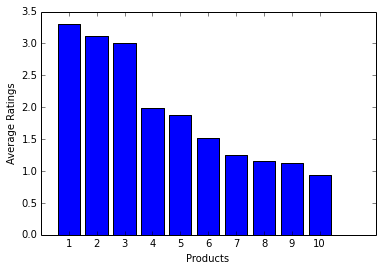

+---------------+--------------+
|  Item Number  | Product ID   |
+===============+==============+
|       1       | B00FF6J532   |
+---------------+--------------+
|       2       | B015JVB9C2   |
+---------------+--------------+
|       3       | B00V2KX5JA   |
+---------------+--------------+
|       4       | B015P3SH9W   |
+---------------+--------------+
|       5       | B011N5HFOE   |
+---------------+--------------+
|       6       | B00NJNE6AA   |
+---------------+--------------+
|       7       | B011KFQASE   |
+---------------+--------------+
|       8       | B00ZOO1RFO   |
+---------------+--------------+
|       9       | B01606KJ6C   |
+---------------+--------------+
|      10       | B00PPTP9IO   |
+---------------+--------------+


In [15]:
#lis = [('p',3),('q',3),('r',5),('s',1)]

Create_Graph(product_touch[:10])